In [10]:
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

### Data Prep

In [11]:
# load data
nike_stock = pd.read_csv(r'data/nike_stock.csv')

In [12]:
nike_stock.head(10)

Date  Close
0  9/18/1981 16:00:00   0.15
1  9/21/1981 16:00:00   0.16
2  9/22/1981 16:00:00   0.15
3  9/23/1981 16:00:00   0.15
4  9/24/1981 16:00:00   0.15
5  9/25/1981 16:00:00   0.15
6  9/28/1981 16:00:00   0.14
7  9/29/1981 16:00:00   0.15
8  9/30/1981 16:00:00   0.15
9  10/1/1981 16:00:00   0.15

In [13]:
# cleaning
nike_stock['Date'] = nike_stock['Date'].astype('datetime64[ns]')
nike_stock['Date'] = nike_stock['Date'].dt.date.astype('datetime64[ns]')
nike_stock.columns = ['Date', 'Price']

In [14]:
# imputations
dates = pd.DataFrame((pd.date_range(start=nike_stock['Date'].min(), end=nike_stock['Date'].max())), columns=['Date'])
nike_stock = nike_stock.merge(dates, on='Date', how='right')
nike_stock['Price'] = nike_stock['Price'].interpolate()

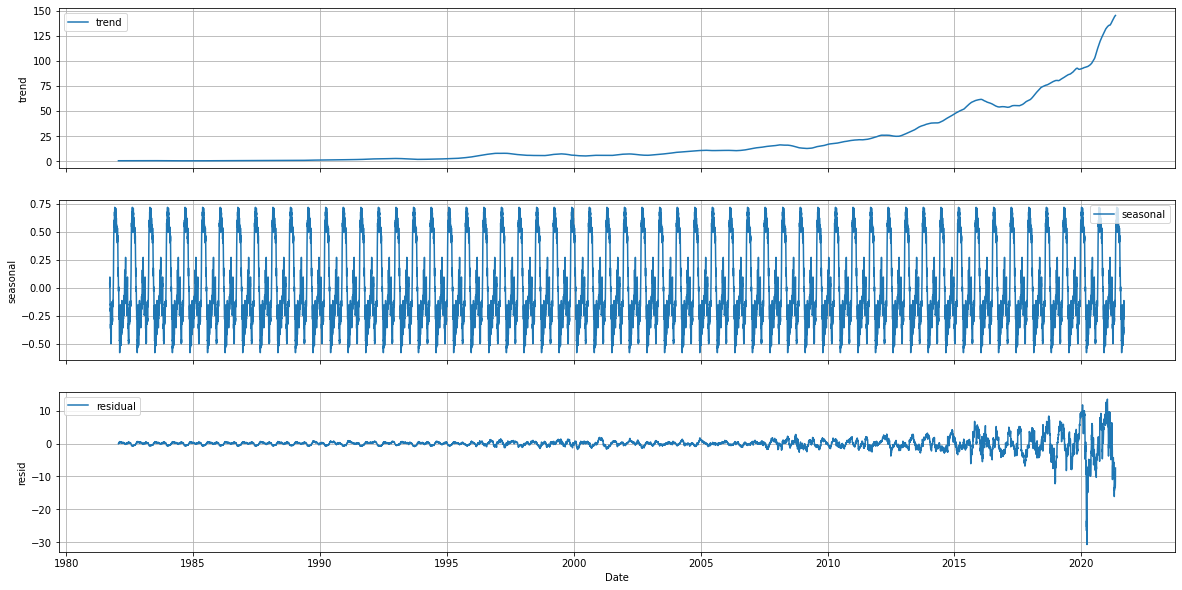

In [15]:
# trend, seasonal, residual
result = sm.tsa.seasonal_decompose(nike_stock.set_index('Date'), period=253)
trend = result.trend
seasonal = result.seasonal
residual = result.resid
'''
The NYSE and NASDAQ average about 253 trading days a year. 
This is from 365.25 (days on average per year) * 5/7 (proportion work days per week) - 6 (weekday holidays) - 3*5/7 (fixed date holidays) = 252.75 ≈ 253. 
The holidays where the stock exchange is closed are 
New Year's Day, 
Martin Luther King, Jr. Day, 
Presidents' Day, 
Good Friday, 
Memorial Day, 
Independence Day, 
Labor Day, 
Thanksgiving Day, 
and Christmas Day; 
there are also some holidays where trading is permitted, including Columbus Day, Veterans Day, and New Year's Eve.
'''
# plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(20, 10))
sns.lineplot(data=trend, ax=ax1, label='trend')
sns.lineplot(data=seasonal, ax=ax2, label='seasonal')
sns.lineplot(data=residual, ax=ax3, label='residual')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show();

### Train Test Split

In [16]:
# train val test split
def make_train_val_test(df, test_size=0.2, n_split=5, shuffle=False):
    '''get train, val, and test data.'''
    
    df = df.reset_index(drop=True)
    if test_size < 1:
        test_size = int(len(df) * test_size)
        #print(test_size)
    
    # test set
    test = df.iloc[-test_size:, :]
    
    # train/val set
    train = df.loc[~df.index.isin(test.index)]
    bags = []
    
    for b in range(n_split):
        bags.append(train.iloc[int(b/5 * len(train)):int((b + 1)/5 * len(train)), :])
    if shuffle:
        random.shuffle(bags)
    
    train = pd.concat(bags[:n_split-1], axis=0)
    val = bags[n_split-1]
    
    return train, val, test

train, val, test = make_train_val_test(nike_stock)

### Modeling

#### ARMA

In [17]:
# train
arma = ARMA(train.set_index('Date'), order=(5, 0)).fit()
print(f'AIC: {arma.aic}')

AIC: -21729.18391306132


In [18]:
# predict train
train_pred = arma.predict(start=train.index[0], end=train.index[-1])
train_pred = train_pred.reset_index()
train_pred.columns= ['Date', 'Price']
train_pred.loc[0, 'Price'] = np.NaN

In [19]:
# predict validation
val_pred = arma.predict(start=val.index[0], end=val.index[-1])
val_pred = val_pred.reset_index()
val_pred.columns= ['Date', 'Price']

<AxesSubplot:xlabel='Date', ylabel='Price'>

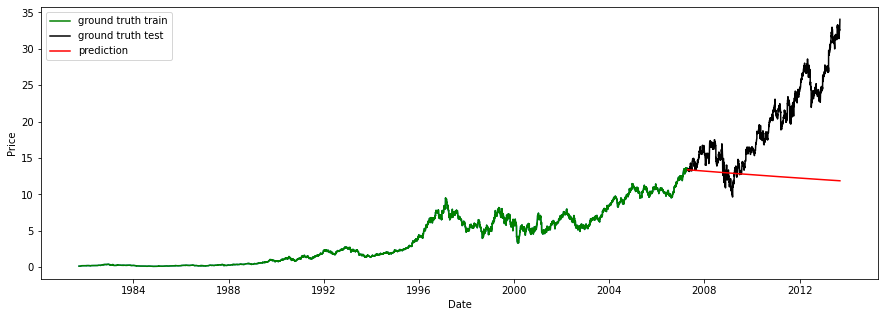

In [20]:
# plot prediction
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='Date', y='Price')
sns.lineplot(data=train_pred, x='Date', y='Price', color='green', label='ground truth train')
sns.lineplot(data=val, x='Date', y='Price', color='black', label='ground truth test')
sns.lineplot(data=val_pred, x='Date', y='Price', color='red', label='prediction')

#### Conclusion: Obey Stationary Assumption, ARMA IS Aparrently NOT Working Well...

#### ARIMA

In [21]:
# train
ps = range(10)
ds = range(10)
qs = range(10)
parameters_list = []
for p in ps:
    for d in ds:
        for q in qs:
            parameters_list.append([p, d, q])

results = []
best_params = None
best_model = None
best_aic = np.inf
for params in parameters_list:  
    try:
        model = sm.tsa.SARIMAX(
            train.set_index('Date'), 
            order=(params[0], params[1], params[2]), 
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit()
        
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_params = params
        results.append([params, aic])
        
    except ValueError:
        print('Params Error:', params)
        continue

best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 9346
Model:               SARIMAX(2, 0, 0)   Log Likelihood               10870.672
Date:                Sun, 26 Sep 2021   AIC                         -21735.344
Time:                        07:51:05   BIC                         -21713.917
Sample:                    09-18-1981   HQIC                        -21728.066
                         - 04-20-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0414      0.005    226.044      0.000       1.032       1.050
ar.L2         -0.0412      0.005     -8.939      0.000      -0.050      -0.032
sigma2         0.0057   1.98e-05    288.326      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            457900.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):             211.64   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# predict train
pred_train = best_model.predict(start=0, end=9345).reset_index()
pred_train.columns = ['Date', 'Pred_Price']
pred_train['Period'] = 'train'
pred_train

Date  Pred_Price Period
0    1981-09-18    0.000000  train
1    1981-09-19    0.156213  train
2    1981-09-20    0.153505  train
3    1981-09-21    0.156839  train
4    1981-09-22    0.160173  train
...         ...         ...    ...
9341 2007-04-16   13.535504  train
9342 2007-04-17   13.595517  train
9343 2007-04-18   13.540975  train
9344 2007-04-19   13.470135  train
9345 2007-04-20   13.368877  train

[9346 rows x 3 columns]

In [23]:
# predict val
pred_val = best_model.predict(start=9346, end=11682).reset_index()
pred_val.columns = ['Date', 'Pred_Price']
pred_val['Period'] = 'val'
pred_val

Date  Pred_Price Period
0    2007-04-21   13.383411    val
1    2007-04-22   13.386550    val
2    2007-04-23   13.389680    val
3    2007-04-24   13.392809    val
4    2007-04-25   13.395940    val
...         ...         ...    ...
2332 2013-09-08   23.081295    val
2333 2013-09-09   23.086690    val
2334 2013-09-10   23.092086    val
2335 2013-09-11   23.097483    val
2336 2013-09-12   23.102882    val

[2337 rows x 3 columns]

In [24]:
# predict test
pred_test = best_model.predict(start=11683, end=14602).reset_index()
pred_test.columns = ['Date', 'Pred_Price']
pred_test['Period'] = 'test'
pred_test

Date  Pred_Price Period
0    2013-09-13   23.108282   test
1    2013-09-14   23.113683   test
2    2013-09-15   23.119086   test
3    2013-09-16   23.124489   test
4    2013-09-17   23.129894   test
...         ...         ...    ...
2915 2021-09-06   45.670301   test
2916 2021-09-07   45.680976   test
2917 2021-09-08   45.691653   test
2918 2021-09-09   45.702333   test
2919 2021-09-10   45.713015   test

[2920 rows x 3 columns]

In [25]:
pred_results = pd.concat([
    pred_train,
    pred_val,
    pred_test
], axis=0)

pred_results

Date  Pred_Price Period
0    1981-09-18    0.000000  train
1    1981-09-19    0.156213  train
2    1981-09-20    0.153505  train
3    1981-09-21    0.156839  train
4    1981-09-22    0.160173  train
...         ...         ...    ...
2915 2021-09-06   45.670301   test
2916 2021-09-07   45.680976   test
2917 2021-09-08   45.691653   test
2918 2021-09-09   45.702333   test
2919 2021-09-10   45.713015   test

[14603 rows x 3 columns]

In [26]:
model_updated = sm.tsa.SARIMAX(
    pd.concat([train, val], axis=0).set_index('Date'), 
    order=(2,0,0),             
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()
model_updated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                11683
Model:               SARIMAX(2, 0, 0)   Log Likelihood                6318.961
Date:                Sun, 26 Sep 2021   AIC                         -12631.922
Time:                        07:51:07   BIC                         -12609.824
Sample:                    09-18-1981   HQIC                        -12624.499
                         - 09-12-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0122      0.004    262.101      0.000       1.005       1.020
ar.L2         -0.0119      0.004     -3.078      0.002      -0.019      -0.004
sigma2         0.0198   5.23e-05    379.154      0.000       0.020       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1299147.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             235.68   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# updated predict test 
pred_test_updated = model_updated.predict(start=11683, end=14602).reset_index()
pred_test_updated.columns = ['Date', 'Pred_Price']
pred_test_updated['Period'] = 'test_updated'
pred_test_updated

Date  Pred_Price        Period
0    2013-09-13   34.055431  test_updated
1    2013-09-14   34.068205  test_updated
2    2013-09-15   34.080952  test_updated
3    2013-09-16   34.093703  test_updated
4    2013-09-17   34.106459  test_updated
...         ...         ...           ...
2915 2021-09-06  101.333959  test_updated
2916 2021-09-07  101.371873  test_updated
2917 2021-09-08  101.409801  test_updated
2918 2021-09-09  101.447743  test_updated
2919 2021-09-10  101.485699  test_updated

[2920 rows x 3 columns]

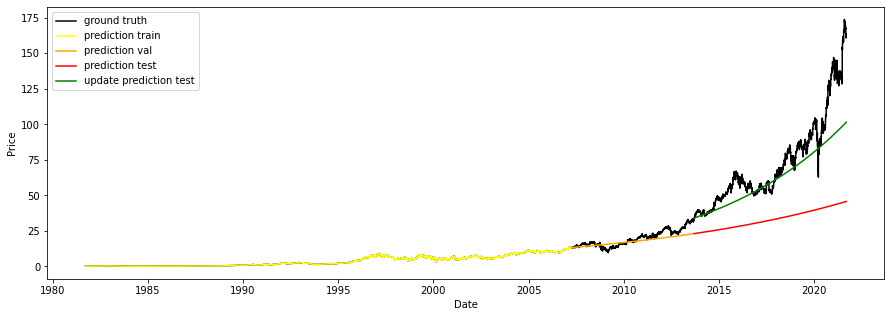

In [28]:
# plot prediction
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='Date', y='Price', color='black', label='ground truth')
sns.lineplot(data=pred_train, x='Date', y='Pred_Price', color='yellow', label='prediction train')
sns.lineplot(data=val, x='Date', y='Price', color='black')
sns.lineplot(data=pred_val, x='Date', y='Pred_Price', color='orange', label='prediction val')
sns.lineplot(data=test, x='Date', y='Price', color='black')
sns.lineplot(data=pred_test, x='Date', y='Pred_Price', color='red', label='prediction test')
sns.lineplot(data=pred_test_updated, x='Date', y='Pred_Price', color='green', label='update prediction test');


In [29]:
final_results = nike_stock.merge(pred_results, on='Date')
final_results

Date       Price  Pred_Price Period
0     1981-09-18    0.150000    0.000000  train
1     1981-09-19    0.153333    0.156213  train
2     1981-09-20    0.156667    0.153505  train
3     1981-09-21    0.160000    0.156839  train
4     1981-09-22    0.150000    0.160173  train
...          ...         ...         ...    ...
14598 2021-09-06  162.802500   45.670301   test
14599 2021-09-07  162.640000   45.680976   test
14600 2021-09-08  160.710000   45.691653   test
14601 2021-09-09  163.340000   45.702333   test
14602 2021-09-10  163.590000   45.713015   test

[14603 rows x 4 columns]